In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
from fastai.vision.all import *
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1 Data preparation

In [3]:
df = pd.read_csv('data_v2.csv', low_memory=False)
df = df[pd.notna(df['img_folder'])]
df = df[df['Year of production'] > 1900]
df = df[df['Case diameter'] > 10]
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Description', 'Reference number', 'price', 'Functions', 'Model', 'img_folder'], inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,Bracelet material,Brand,Case diameter,Case material,Condition,Dial,Gender,Location,Movement,Scope of delivery,...,GMT,Tachymeter,Moon phase,Annual calendar,Perpetual calendar,Tourbillon,Flyback,Alarm,Country,is_valid
0,Steel,Bulgari,41.0,Steel,New,Black,Men's watch/Unisex,"United States of America, California, San Mateo",Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,United States of America,0
1,Steel,Longines,40.0,Steel,New,Blue,Men's watch/Unisex,"United Kingdom, London",Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,United Kingdom,0
2,Steel,Omega,42.0,Steel,Very good,Black,Men's watch/Unisex,"Germany, Iffezheim",Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,Germany,0
3,Steel,Longines,40.0,Steel,New,Silver,Men's watch/Unisex,"United Kingdom, London",Automatic,"Original box, original papers",...,0,0,0,0,0,0,0,0,United Kingdom,0
4,Gold/Steel,Breitling,39.0,Gold/Steel,Good,Blue,Men's watch/Unisex,"United Kingdom, Radlett",Automatic,"Original box, no original papers",...,0,0,0,0,0,0,0,0,United Kingdom,0


In [4]:
def splitter(df):
    train = df.index[df['is_valid'] == 0].tolist()
    valid = df.index[df['is_valid'] == 1].tolist()
    return train,valid

def get_x(r): return './images/{}.jpg'.format(r['id'])
def get_y(r): return r['Brand']

Test if the get functions work

In [5]:
get_y(df.loc[0]), get_x(df.loc[0])

('Bulgari', './images/d9113598.jpg')

# 2 Image classification with a Neural Net
The first model will be a neural network trained on the corresponding pictures of watches.

## Set up the dataloader
The data is split into train and validation sets at a 80/20 ratio. <br>
Images are resized to 256x256 pixels. A lot of product pictures are slightly tilted so I apply random rotations between -20 and +20 degrees to account for this.

In [6]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(256),
                   batch_tfms=Rotate(max_deg=20))
dls = dblock.dataloaders(df)

In [7]:
len(dls.train_ds),len(dls.valid_ds)

(36288, 9098)

Test if GPU is working.

In [8]:
dls.device

device(type='cuda', index=0)

Take a random batch to see if everything is working as intended. <br>
Pictures like the Omega and Breitling might cause problems, since there is a lot of stuff in the image. The others look pretty good.

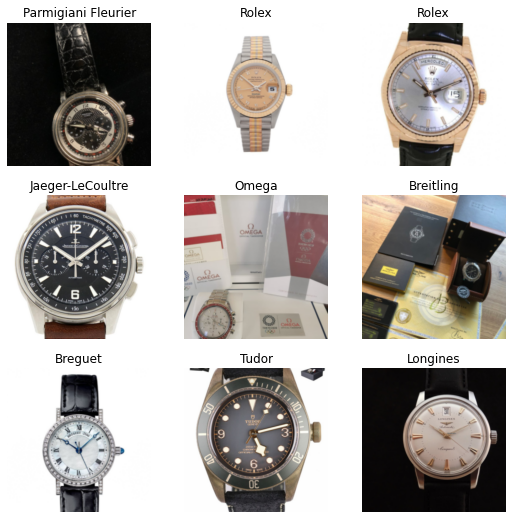

In [10]:
dls.show_batch(nrows=3, ncols=3)

## Training the neural net
Training an image classifier is very time consuming, so I use transfer learning on Resnet18. <br>
To get an additional big speedup I use half precision.

In [12]:
learn = cnn_learner(dls, resnet18, metrics=error_rate).to_fp16()

Find an appropriate learning rate.

SuggestedLRs(valley=0.0014454397605732083)

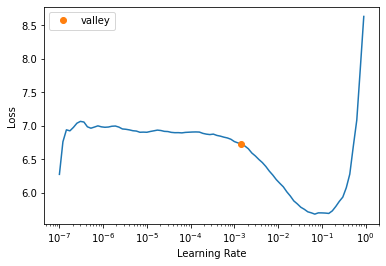

In [13]:
learn.lr_find()

Train the all layers of Resnet for one epoch and then train the last layer for 5 additional epochs.

In [14]:
learn.fine_tune(5, base_lr=0.0015)

epoch,train_loss,valid_loss,error_rate,time
0,2.373662,1.807495,0.413497,02:04


epoch,train_loss,valid_loss,error_rate,time
0,1.539969,1.235347,0.288525,02:02
1,1.131867,0.937542,0.222576,02:03
2,0.815675,0.749372,0.172346,02:03
3,0.571824,0.683638,0.158606,02:03
4,0.466882,0.671293,0.153770,02:04


In [15]:
preds_img,targs = learn.get_preds()

9098 images in the validation set, 152 target brands.

In [17]:
preds_img.shape

torch.Size([9098, 152])

## Results
Accuracy is very good at 84%. This is remarkable since the model was only trained for about 12 minutes and there are a number of low quality images in the dataset.

In [99]:
accuracy_score(targs, to_np(np.argmax(preds_img, axis=1)))

0.8462299406462959

## Confusion
Since there are over 150 target categories, a confusion matrix would be confusion indeed (pun!). <br>
When looking at the most confused brands, we see a lot of Rolex, Omega and Tudor. This doesnt come as a surprise, as they're all known for steel watches with steel bracelets and diving bezels. <br>
Overall, these look like reasonable confusions, which would happen to an untrained human eye as well. A good sign for the model.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [19]:
interp.most_confused(min_val=10)

[('Rolex', 'Omega', 19),
 ('Omega', 'Rolex', 18),
 ('Tudor', 'Rolex', 16),
 ('Seiko', 'Omega', 14),
 ('TAG Heuer', 'Omega', 14),
 ('TAG Heuer', 'Seiko', 14),
 ('IWC', 'Omega', 11),
 ('Tudor', 'Omega', 11),
 ('Omega', 'Seiko', 10),
 ('Zenith', 'Omega', 10)]

# 3 Random Forest
In the next step, I will classify watch brands based on the specifications of their watches using a random forest.

In [6]:
df.drop(columns=['id'], inplace=True)

Aside from the year of production and case diameter, all features are categorical. I set the data type to make sure everything works as intended later on.
For some categories I can set an internal order to make the decision tree more efficient. In the case of materials the order is a bit arbitrary, but precious metals should definitely be separated from steel and other affordable materials.

In [7]:
cat_columns = ['Bracelet material', 'Brand', 'Case material',
       'Condition', 'Dial', 'Gender', 'Location', 'Movement',
       'Scope of delivery', 'private_seller', 'Crystal',
       'Date', 'Weekday', 'Month', 'Chronograph', 'GMT',
       'Tachymeter', 'Moon phase', 'Annual calendar', 'Perpetual calendar',
       'Tourbillon', 'Flyback', 'Alarm', 'Country']


for c in cat_columns:
    df[c] = df[c].astype('category')

In [8]:
def order_category(cat, order):
    df[cat] = df[cat].astype('category')
    df[cat] = df[cat].cat.set_categories(order, ordered=True)

In [9]:
bracelet = 'Platinum','White gold','Rose gold','Yellow gold','Gold/Steel','Silver', 'Titanium', 'Ceramic', 'Steel', 'Aluminium', 'Leather', 'Textile', 'Rubber'
order_category('Bracelet material', bracelet)

case = 'Platinum', 'White gold', 'Rose gold', 'Yellow gold', 'Gold/Steel', 'Silver', 'Titanium', 'Ceramic', 'Steel', 'Bronze', 'Carbon','Plastic',  'Aluminum', 'Other'
order_category('Case material', case)

condition = 'New', 'Unworn', 'Very good', 'Good', 'Fair', 'Poor'
order_category('Condition', condition)

movement = 'Automatic', 'Manual winding', 'Quartz'
order_category('Movement', movement)

delivery = 'Original box, original papers', 'Original papers, no original box', 'Original box, no original papers', 'No original box, no original papers', 
order_category('Scope of delivery', delivery)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45386 entries, 0 to 45385
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Bracelet material   45386 non-null  category
 1   Brand               45386 non-null  category
 2   Case diameter       45386 non-null  float64 
 3   Case material       45386 non-null  category
 4   Condition           45386 non-null  category
 5   Dial                45386 non-null  category
 6   Gender              45386 non-null  category
 7   Location            45386 non-null  category
 8   Movement            45386 non-null  category
 9   Scope of delivery   45386 non-null  category
 10  Year of production  45386 non-null  float64 
 11  private_seller      45386 non-null  category
 12  Crystal             45386 non-null  category
 13  Date                45386 non-null  category
 14  Weekday             45386 non-null  category
 15  Month               45386 non-null  

## Set up training and validation datasets
I use the TabularPandas class of FastAI to construct my datasets. <br>
Categorical variables are ordinal encoded and the data is split 80/20 into training and validation sets.

In [11]:
cont,cat = cont_cat_split(df.drop(columns=['is_valid']), 1, dep_var='Brand')

In [12]:
to = TabularPandas(df.drop(columns=['is_valid']), [Categorify], cat, cont, y_names='Brand', y_block=CategoryBlock(), splits=splitter(df))

In [13]:
len(to.train),len(to.valid)

(36288, 9098)

In [14]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

The results of the spec based classification arent quite as good compared to the image classification. <br>
The random forest model is still able to achieve an accuracy of 70%. <br>
It would probably be possible to squeeze out a few more permille tuning the hyper parameters. 100 estimators seem to be enough based on a plot against mean squared error.

In [15]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=100)
model.fit(xs.values, y)

RandomForestClassifier(n_jobs=-1)

In [ ]:
accuracy_score(valid_y, model.predict(valid_xs.values))

In [16]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [17]:
m_rmse(model, xs.values, y), m_rmse(model, valid_xs.values, valid_y)

(6.198972, 33.663443)

In [18]:
preds_n_est = np.stack([t.predict(valid_xs.values) for t in model.estimators_])

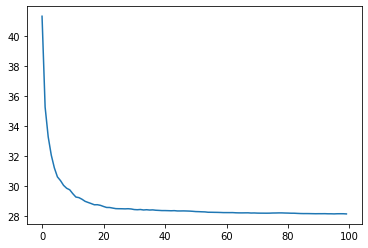

In [19]:
plt.plot([r_mse(preds_n_est[:i+1].mean(0), valid_y) for i in range(100)])

## Feature importance
There dont seem to be any features without information content, so there is not really a reason to reduce the model complexity. <br>

<AxesSubplot:ylabel='cols'>

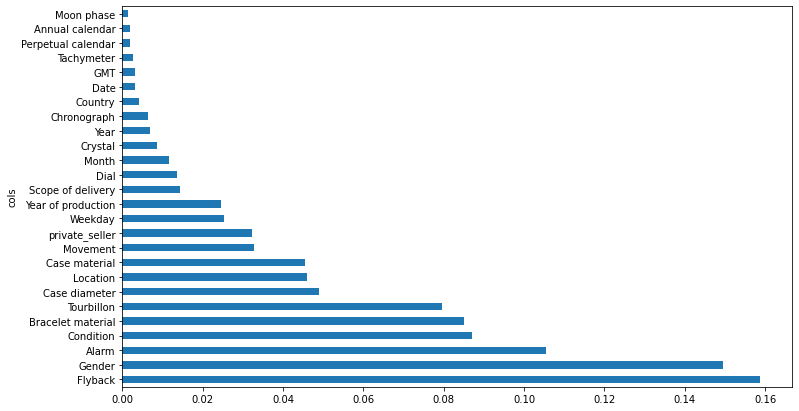

In [21]:
fi = pd.DataFrame({'cols':df.columns.drop(['Brand', 'is_valid']), 'imp':model.feature_importances_}).sort_values('imp', ascending=False)
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

# 4 Ensemble
In the last step, I will ensemble the results of both models to hopefully improve accuracy. <br>
The predicted probabilities of both models are added up and the target with the highest sum is chosen as the prediction. <br>
Accuracy improves by 3% compared to the image classification. The ensemble is able to correctly predict 87% of watch brands in the validation set. This is pretty good in my opinion, considering there are quite a few watches with bad pictures or missing/false specifications.

In [37]:
preds_specs = model.predict_proba(valid_xs.values)
preds_specs.shape

(9098, 152)

In [120]:
ens_preds = (to_np(preds_img.squeeze()) + preds_specs) 

In [123]:
accuracy_score(targs, np.argmax(ens_preds, axis=1))

0.871620136293691